In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import os
import pathlib
from joblib import Parallel, delayed

from skimage import exposure, measure, util
from skimage.filters import threshold_otsu, gaussian
from skimage.measure import label, regionprops, regionprops_table
from skimage.morphology import remove_small_holes, remove_small_objects, disk, erosion
from skimage.segmentation import  expand_labels
from scipy.ndimage import distance_transform_edt

from tifffile import imread

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from textwrap import wrap
from matplotlib.pyplot import cm

import warnings
warnings.filterwarnings('ignore')

In [2]:
def convert(img, target_type_min, target_type_max, target_type):
    """
    Converts an image to a specified data type while scaling its intensity values.

    This function rescales the intensity values of an image from its original range 
    to a new target range specified by `target_type_min` and `target_type_max`, and 
    then converts it to the desired data type.

    This step is required as deconvolved images are not always scaled 0->255! 

    Parameters:
    -----------
    img : numpy.ndarray
        The input image array to be converted.
    target_type_min : int or float
        The minimum value of the target intensity range.
    target_type_max : int or float
        The maximum value of the target intensity range.
    target_type : numpy.dtype
        The desired data type of the output image (e.g., np.uint8, np.float32).

    Returns:
    --------
    new_img : numpy.ndarray
        The rescaled image with values mapped to the new intensity range and converted 
        to the specified data type.

    Notes:
    ------
    - This function performs a linear transformation to scale pixel values.
    - It ensures that the output values are properly mapped between `target_type_min` and 
      `target_type_max`.
    """
    imin = img.min()
    imax = img.max()

    a = (target_type_max - target_type_min) / (imax - imin)
    b = target_type_max - a * imax
    new_img = (a * img + b).astype(target_type)
    return new_img

In [3]:
def add_image_details(df, filename, flag):
    """
    Adds experimental details extracted from the filename to a dataframe.

    This function parses the filename to infer experimental details such as 
    well number, imaging day, mechanical stiffness condition, and treatment type.
    The extracted details are appended as new columns to the dataframe.

    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe to which image metadata will be added.
    filename : str
        The filename of the image, used to extract experimental details.
    flag : str
        A flag indicating any segmentation issues detected during processing.

    Returns:
    --------
    df : pandas.DataFrame
        The updated dataframe with the following added columns:
        - 'filename': The original filename.
        - 'flag': Segmentation flag indicating potential issues.
        - 'well': The well number (1 or 2) inferred from the filename.
        - 'day': The experimental time point (0, 1, 3, or 7 days).
        - 'condition': The mechanical stiffness condition ('soft', 'stiff', or 'blank').
        - 'treatment': The treatment applied ('blebbistatin', 'ROCKi', 'batimastat', 'ABT737', or 'none').
        - 'image_type': A combined descriptor of the condition and day (e.g., 'soft, d3').
    """
    df["filename"] = filename
    df["flag"] = flag
    if ("well1" in filename):
        df["well"] = 1
    else:
        df["well"] = 2
    # Day #        
    if "d0" in filename:
        df["day"] =  0
    elif "d1" in filename:
        df["day"] =  1
    elif "d3" in filename:
        df["day"] =  3
    else:
        df["day"] =  7
    # Stiffness
    if 'soft' in filename:
        df["condition"] =  'soft'
    elif 'stiff' in filename:
        df["condition"] =  'stiff'
    else:
        df["condition"] =  'blank'
    df['image_type'] = df["condition"].astype(str) + ", d" + df["day"].astype(str)

    return df

In [4]:
def calculate_distance_map(path, DAPI_channel=1, membrane_channel = 0, bm_channel=2, to_plot=True, colour="black"):
    filename = os.path.basename(path).replace("_", "").lower()
    try:
        flag = "None"
        multi_channel_image = convert(imread(path), 0,255, np.uint8)
        acinus_image = (multi_channel_image[DAPI_channel,:,:] + multi_channel_image[membrane_channel,:,:]) # approximate the acinus as membrane + dapi
        bm_image = (multi_channel_image[bm_channel,:,:]) 

        clipped = acinus_image.clip(min =np.quantile(acinus_image, 0.1), max = np.quantile(acinus_image, 0.85))
        acinus_smoothed = gaussian(clipped, sigma = 3)
        thresh = threshold_otsu(acinus_smoothed)
        binary = acinus_smoothed > thresh

        binary = remove_small_holes(binary, area_threshold = 100000)
        binary = remove_small_objects(binary, min_size = 10000)

        labelled_image = label(binary)
        table = regionprops_table(labelled_image, properties=('label', "area"),) #only keep largest acinus
        condition = (table['area'] >= (table["area"]).max())
        input_labels = table['label']
        output_labels = input_labels * condition
        filtered_labelled_image = util.map_array(labelled_image, input_labels, output_labels)
        filtered_labelled_image = expand_labels(filtered_labelled_image, distance=3)

        table = regionprops_table(filtered_labelled_image, properties=('label', 'eccentricity'),) #test sphericity of largest identified acinus
        condition = table['eccentricity']>= (0.55)
    ################################################################################################################
        if condition == False:
            #low sphericity could mean that 2 neighbouring acini have been imaged. Attempt to separate these with heavy erosion if so
            flag = "multiple_acini_split"
            acinus_smoothed = gaussian(clipped, sigma = 1)
            thresh = threshold_otsu(acinus_smoothed)
            binary = acinus_smoothed > thresh
            binary = remove_small_holes(binary, area_threshold = 100000)
            binary = remove_small_objects(binary, min_size = 10000)
            binary = erosion(binary, disk(8))
            labelled_image = label(binary)
            table = regionprops_table(labelled_image, properties=('label', "area"),)
            condition = (table['area'] >= (table["area"]).max())
            input_labels = table['label']
            output_labels = input_labels * condition
            filtered_labelled_image = util.map_array(labelled_image, input_labels, output_labels)
            filtered_labelled_image = expand_labels(filtered_labelled_image, distance=8)
            
    # ################################################################################################################
        bm_image = bm_image * (filtered_labelled_image) #clean bm image to focus on bm in/around identified acinus
        distance = (distance_transform_edt(filtered_labelled_image))
        r = np.sqrt((3* regionprops(filtered_labelled_image)[0].area)/(np.pi))
        distance = distance/r
        intensity_with_distance = pd.DataFrame(zip(np.ravel(distance), np.ravel(bm_image)), columns=['distance/radius', 'bm_intensity'])    
        intensity_with_distance['rounded_distance'] = intensity_with_distance["distance/radius"].apply(lambda x: round(x, 2))
        intensity_with_distance = intensity_with_distance.groupby(['rounded_distance'], as_index=False)["bm_intensity"].mean()

        intensity_with_distance = add_image_details(intensity_with_distance, filename, flag) #fill in df with experimental details extracted from filename

        if to_plot == True:
            fig, ax = plt.subplots(nrows = 1, ncols = 7, figsize=(20,4))
            ax[0].imshow(20*acinus_image , cmap = "gray")
            ax[1].imshow(acinus_smoothed, cmap="gray")
            ax[2].imshow(labelled_image, cmap = "gray")
            ax[3].imshow(filtered_labelled_image, cmap = "gray")
            ax[4].imshow(distance, cmap = "gray")
            ax[5].imshow(bm_image, cmap = "gray")
            cols = ["Original", "Clipped",  "Identified Objects", "Largest Acinus", "Distance Map", "Clean BM", "Intensity v Dist"]
            for i in range(6):
                if i !=7:
                    ax[i].set_xticks([])
                    ax[i].set_yticks([])
                ax[i].set_title(cols[i]) 
            
            to_plot = intensity_with_distance.groupby(['rounded_distance'], as_index=False)["bm_intensity"].mean()
            to_plot["bm_intensity"] = to_plot["bm_intensity"]/ to_plot["bm_intensity"].max()
            sns.lineplot(data = to_plot, x="rounded_distance", y = "bm_intensity", ax = ax[-1], color="red")
            #plt.savefig("Segmented{}.png".format(colour), bbox_inches="tight", transparent="True")

            return filtered_labelled_image, acinus_image, bm_image, intensity_with_distance
        else:
            return intensity_with_distance
    except:
        intensity_with_distance = pd.DataFrame()
        intensity_with_distance["filename"] = filename
        intensity_with_distance["flag"]= "IMAGE FAILED"
   

In [5]:
image_paths = list(pathlib.Path("E:/PROTEIN_COLOCALISATION_IMAGES/Deconvolved_Images/Lam_Pax_DECONVOLVED/slices_for_2d_example/output").rglob("*.tif"))

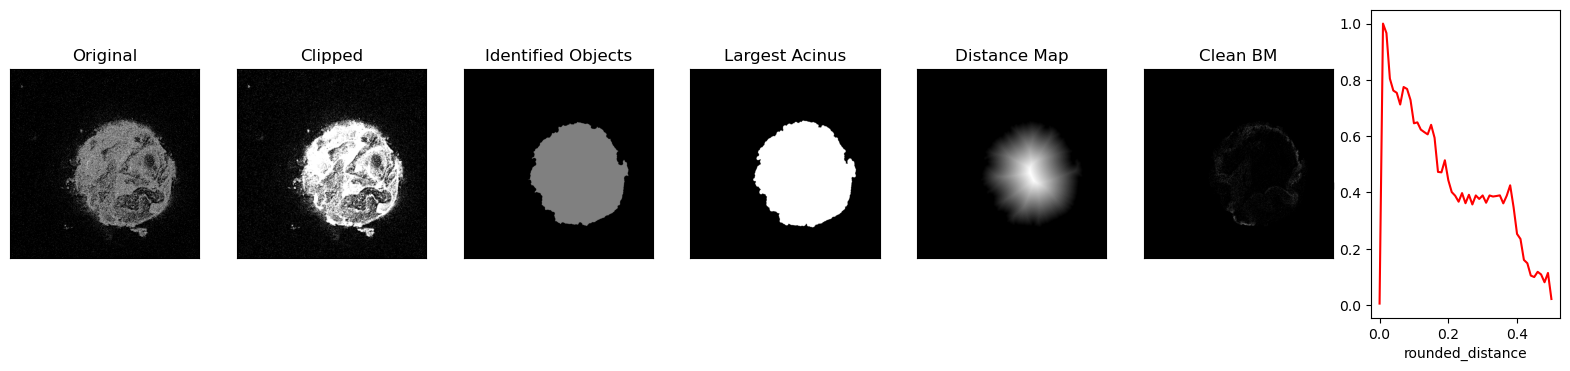

In [33]:
calculate_distance_map(image_paths[9], to_plot = True)

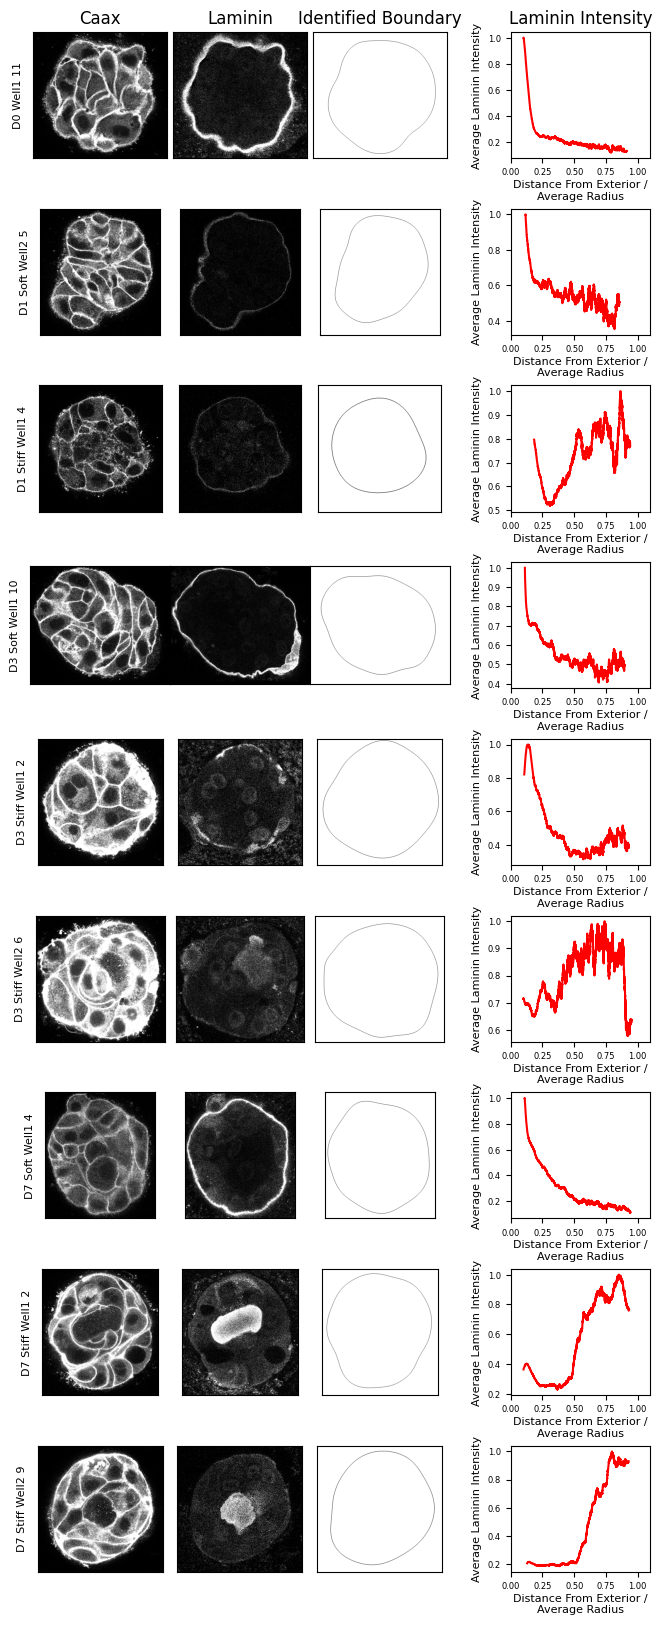

In [21]:
# gridspec = dict(hspace=0.4, wspace=0.0, width_ratios=[0.8, 0.8, 0.8, 0.35, 0.8])
# fig, axs = plt.subplots(nrows=len(caax_images), ncols = 5 , gridspec_kw = gridspec, figsize = (8,20))

# for i in range(len(caax_images)):
#     distance, inverted, r, labelled = calculate_distance_map(caax_images[i])

#     axs[i][0].imshow(caax_images[i], cmap="gray")
#     axs[i][1].imshow(laminin_images[i], cmap="gray")    
#     axs[i][2].imshow(inverted, cmap="gray")
#     axs[i][3].set_visible(False)
    
#     intensity_with_distance = pd.DataFrame(zip(np.ravel(distance), np.ravel(laminin_images[i])), columns=['Distance', 'Intensity'])
    
#     to_plot = intensity_with_distance\
#                 .groupby('Distance', as_index = False)\
#                     .Intensity\
#                         .mean()

#     to_plot['Intensity'] = to_plot['Intensity'].rolling(500).mean()
#     to_plot["Intensity"] = to_plot["Intensity"]/ to_plot["Intensity"].max()
#     sns.lineplot(data = to_plot, x="Distance", y="Intensity", ax=axs[i][-1], color= "r")

# cols = ["Caax", "Laminin", "Identified Boundary","", "Laminin Intensity"]

# for ax, col in zip(axs[0], cols):
#     ax.set_title(col, color=colour)
# for ax, row in zip(axs[:,0], row_names):
#     ax.set_ylabel('\n'.join(wrap(row, 35)), fontsize=8, rotation=90, color=colour) 

# for i in range(len(caax_images)):
#     axs[i][-1].tick_params(axis='both', which='major', labelsize=6,  color=colour)
#     axs[i][-1].tick_params(axis='both', colors=colour)
#     for j in range(3):
#         axs[i][j].set_yticks([])
#         axs[i][j].set_xticks([])
        
#     xlabel_name = "Distance From Exterior / Average Radius"
#     ylabel_name = "Average Laminin Intensity"
#     axs[i][-1].set_ylabel('\n'.join(wrap(ylabel_name, 35)), fontsize=8, color=colour) 
#     axs[i][-1].set_xlabel('\n'.join(wrap(xlabel_name, 30)), fontsize=8, labelpad=2, color=colour) 
#     axs[i][-1].set_xlim(0,1.1)
# plt.savefig("2dlaminin{}.png".format(colour), transparent = True, bbox_inches="tight")